In [1]:
import yfinance as yf
import numpy as np
from datetime import datetime as DT
import pandas as pd

from sympy import symbols, simplify, diff, lambdify
import pandas_datareader as pdr
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as sc
from scipy.differentiate import derivative as deriv


# Week 1 - Return Types, Setup, and Data Foundations


In [2]:
def close_column(df,ticker):
    new_df = df[ticker]['Close'].to_frame()
    new_df.rename(columns={'Close':f"CLOSE_{ticker}"},inplace=True)
    return new_df


def grab_ticker(ticker_list,start,end):
    raw_data = yf.download(ticker_list,start=start,end=end,group_by='ticker',keepna=True)
    pruned_data = None
    for ticker in ticker_list:
        if pruned_data is None:
            pruned_data = close_column(raw_data,ticker)
        else:
            pruned_data = pruned_data.merge(close_column(raw_data,ticker),how='outer',on='Date')

        pruned_data[f"SIMPLE_{ticker}"] = pruned_data[f"CLOSE_{ticker}"].pct_change()
        pruned_data[f"LOG_{ticker}"] = np.log(1+pruned_data[f"SIMPLE_{ticker}"])

        pruned_data[f"CUM_LOG_{ticker}"] = pruned_data[f"LOG_{ticker}"].fillna(0).cumsum()
        pruned_data[f"CUM_SIMPLE_{ticker}"] = (pruned_data[f"SIMPLE_{ticker}"].fillna(0) + 1).cumprod() - 1

    return pruned_data

def single_year_data(df, year):
    return df.iloc[df.index.year == year]

In [66]:
start_date = DT(year=2023,month=1,day=1)
end_date = DT(year=2024,month=12,day=31)
stocks = ['GOOGL','NVDA']
financial_data = grab_ticker(stocks,start=start_date,end=end_date)

C:\Users\Austen Couvertier\AppData\Local\Temp\ipykernel_18744\1264378898.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(ticker_list,start=start,end=end,group_by='ticker',keepna=True)
[*********************100%***********************]  2 of 2 completed


<Axes: xlabel='Date'>

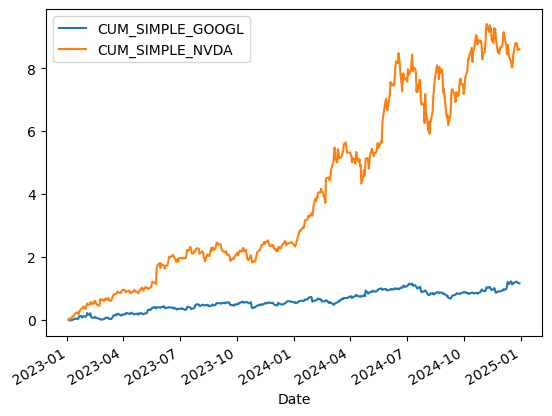

In [67]:
financial_data.plot(y=[f"CUM_SIMPLE_{stock}" for stock in stocks])

<Axes: ylabel='Frequency'>

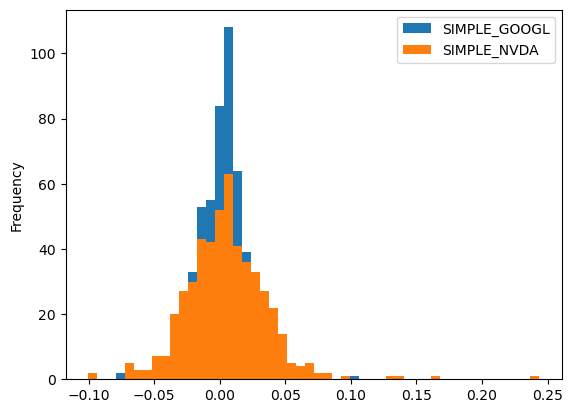

In [68]:
financial_data[[f"SIMPLE_{stock}" for stock in stocks]].plot(kind='hist',bins=50)

# Week 2 - Distributions + Cumulative Returns + Intro to Bonds

In the Coursera - Investment Management Course by Geneve University they introduce to methods of valuation in Module 1 (Understanding Financial Markets)

- Discounting (Net Present Value)
- Comparative Analysis (Via Multiples)

### Discounting

If you have a stream of cashflows (np.array of floats) and a discount rate (assumed risk-free rate of growth) that is constant you can discount future cashflow values to the corresponding "present value". 

- Present Value: The amount of money invested at t = 0 to recover the future value under constant growth given by the discount rate

The equation is: 

$$

NPV = \sum_{i=0}^{N}\frac{c_{i}}{(1+r)^{i}}

$$

Where $r$ is the discount rate and $c_{i}$ is the cash flow at timepoint $i$. In this case $c_{0}$ is the initial investment. If $NPV > 0$ the investment is considered favorable, $<0$ is to be avoided.



In [23]:
def npv(discount_rate, cash_flow,interpret):
    flow_size = len(cash_flow)
    discount_multipliers = np.array([1/((1+discount_rate)**i) for i in range(flow_size)])
    pre_sum = discount_multipliers * cash_flow
    npv = np.sum(pre_sum)
    if interpret:
        if npv > 0:
            print(f"The net present value is {npv}, which represents a sound investment.")
        elif npv < 0:
            print(f"The net present value is {npv}, which represents a bad investment.")
        else:
            print("The net present value is 0, the investment is ambiguous under this measure.")
        
    return npv


At present, this only account for finite cashflows and disregards things like company debt, long term growth and capital costs. Under the assumption of fixed growth beyond some time horizon ($g$), and a fixed weighted average of capital cost ($r_{c}$), we can determine the *terminal value* ($TV$) assuming the cashflow is infinite and the sum under constant growth converges. (Note: In *A Random Walk Down Wall Street*, this point is highlighted as acount for profits in the future and the here-after). The equation is: 

$$
TV = \frac{1+g}{r_{c}-g}FCF_{N}
$$

Where $FCF_{N}$ is the last known *free cash flow* of the company's financial statements.

In [24]:
def terminal_value(growth_rate,capital_cost,final_flow):
    return ((1+growth_rate)/(capital_cost - growth_rate))*final_flow

We can then discount this using the same multiplier as the final cash to give the *discounted cash flow* ($DCF$):

$$
DCF = \sum_{i=1}^{N}\frac{FCF_{i}}{(1+r_{c})^{i}} + \frac{TV}{(1+r_{c})^{N}},
$$

which is a spin on *NPV*.

In [25]:
def dcf(growth_rate, capital_cost, free_cash_flow):
    flow_size = len(free_cash_flow)
    discount_multiplier = np.array([1/((1+capital_cost)**i) for i in range(1,flow_size+1)])
    t_v = terminal_value(growth_rate, capital_cost, free_cash_flow[-1])
    pre_sum = discount_multiplier*free_cash_flow
    return np.sum(pre_sum) + (t_v/(1+capital_cost)**(flow_size))

Lastly, we can account for exisiting debt $D$ and outstanding stock shares $s$ to derive the *enterprise value* ($EV$) and *fair stock price* ($p_{f}$)

$$
EV = DCF
$$

$$
p_{f} = \frac{EV - D}{s}
$$

In [26]:
def fair_stock(debt,shares_outstanding,growth_rate, capital_cost, free_cash_flow):
    enterprise_value = dcf(growth_rate, capital_cost, free_cash_flow)
    return (enterprise_value - debt) / shares_outstanding

In [27]:
def single_moment_set(df,column):
    column_data = df[column]
    return pd.DataFrame(
        data=[column_data.mean(),column_data.std(),column_data.skew(),column_data.kurtosis()],
        index=["mean","std","skew","kurt"],
        columns=[column]
        )


def moments_df(df):
    columns = df.columns
    new_df = None
    for column in columns:
        if new_df is None:
            new_df = single_moment_set(df,column)
        else:
            new_df = new_df.join(single_moment_set(df,column))
    
    return new_df

def gaussian_overlay(df,column_name,plt):
    series = df[column_name]
    
    mu = series.mean()
    std = series.std()
    plot_domain = np.arange(series.min(),series.max(),(series.max()-series.min())/200)
    normal_range = sc.norm.pdf(plot_domain,loc=mu,scale=std)
    
    pruned_series = series.dropna().to_numpy()

    plt.plot(plot_domain,normal_range)
    _ = plt.hist(pruned_series,bins=50,density=True)
    
    return None

def gaussian_qqplot(df,column_name):
    series = df[column_name]
    mu = series.mean()
    
    pruned_series = series.dropna().to_numpy()
    _ = sm.qqplot(pruned_series,line='s',loc=mu)
    return None

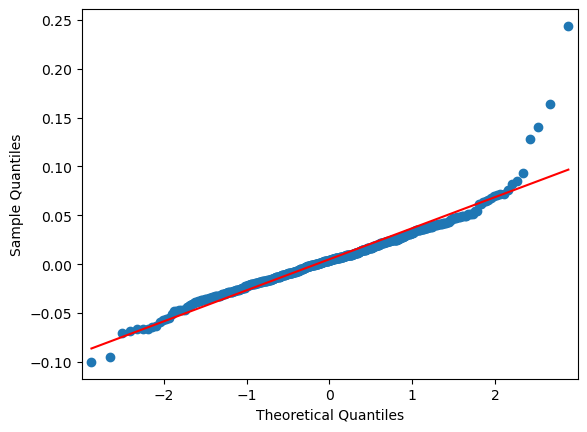

In [28]:
gaussian_qqplot(financial_data,'SIMPLE_NVDA')

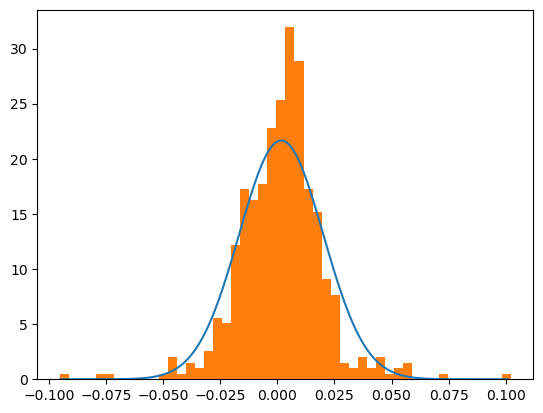

In [29]:
gaussian_overlay(financial_data,'SIMPLE_GOOGL',plt)

In [52]:
def get_bond_data(fred_ticker,start,end):
    raw_data = pdr.fred.FredReader(fred_ticker,start=start,end=end).read()
    daily_data = ((1+raw_data[fred_ticker]/100)**(1/252) - 1)
    return daily_data.rename_axis("Date")

In [55]:
daily_bond_data = get_bond_data(["DGS3MO"],start=start_date,end=end_date)

In [ ]:
stock_bond_data = financial_data.merge(daily_bond_data,how='left',on='Date')
stock_bond_data["DGS3MO"] = stock_bond_data["DGS3MO"].ffill()

In [63]:
stock_bond_moments = moments_df(stock_bond_data)
stock_bond_moments.head()

,CLOSE_GOOGL,SIMPLE_GOOGL,LOG_GOOGL,CUM_LOG_GOOGL,CUM_SIMPLE_GOOGL,CLOSE_NVDA,SIMPLE_NVDA,LOG_NVDA,CUM_LOG_NVDA,CUM_SIMPLE_NVDA,DGS3MO
mean,140.550597,0.001705,0.001534,0.441536,0.586552,72.187605,0.005028,0.004526,1.435478,4.047277,0.000202
std,27.393125,0.018414,0.018412,0.203594,0.309217,41.093839,0.031811,0.031171,0.630855,2.873236,0.000014
skew,-0.088791,-0.046602,-0.228350,-0.441686,-0.088791,0.405088,1.226333,0.873338,-0.221032,0.405088,-0.951664
kurt,-0.855164,4.606920,4.708662,-0.619597,-0.855164,-1.309947,7.972428,5.831130,-1.079915,-1.309947,-0.544188


In [71]:
def static_sharpe(moments, stocks, bond):
    sharpes = [(moments[f"SIMPLE_{stock}"]["mean"] - moments[bond]["mean"])/(moments[f"SIMPLE_{stock}"]["std"]) for stock in stocks]
    return pd.DataFrame(data=sharpes,index=stocks,columns=['static_sharpe'])

In [72]:
static_sharpe(stock_bond_moments,stocks,"DGS3MO")

,static_sharpe
GOOGL,0.081588
NVDA,0.151698


# Week 3 - Regression, Volatility, Bond Valuation

In [79]:
def rolling_statistics(stocks,fred_ticker,start,end,rolling_window):
    all_stocks = grab_ticker(stocks,start=start,end=end)
    
    bond_data = get_bond_data(fred_ticker,start,end)

    all_stocks = all_stocks.merge(bond_data,how='inner',on='Date')
    all_stocks.ffill(inplace=True)

    rolling_data = all_stocks.rolling(window=rolling_window)
    all_stocks[f"{rolling_window}_MEAN_{fred_ticker}"] = rolling_data[fred_ticker].mean()
    
    for stock in stocks:
        all_stocks[f"{rolling_window}_STD_{stock}"] = rolling_data[f"SIMPLE_{stock}"].std()
        all_stocks[f"{rolling_window}_MEAN_{stock}"] = rolling_data[f"SIMPLE_{stock}"].mean()
        all_stocks[f"{rolling_window}_EXCESS_RETURN_{stock}"] = all_stocks[f"{rolling_window}_MEAN_{stock}"]- all_stocks[f"{rolling_window}_MEAN_{fred_ticker}"]
        all_stocks[f"{rolling_window}_SHARPE_{stock}"] = (all_stocks[f"{rolling_window}_EXCESS_RETURN_{stock}"])/all_stocks[f"{rolling_window}_STD_{stock}"]
    
    return all_stocks

In [83]:
window = "30D"
stocks = ['SPY','GOOGL','NVDA']
bond_type = 'DGS3MO'
full_financial_data = rolling_statistics(stocks,bond_type,start_date,end_date,window)


C:\Users\Austen Couvertier\AppData\Local\Temp\ipykernel_18744\1264378898.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(ticker_list,start=start,end=end,group_by='ticker',keepna=True)
[*********************100%***********************]  3 of 3 completed


<Axes: xlabel='Date'>

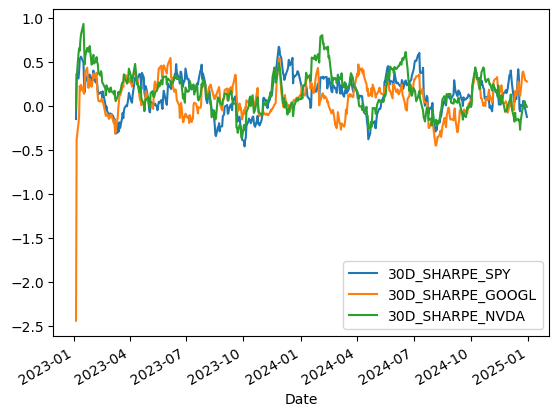

In [84]:
full_financial_data[[f"{window}_SHARPE_{stock}"for stock in stocks]].plot()

<Axes: xlabel='Date'>

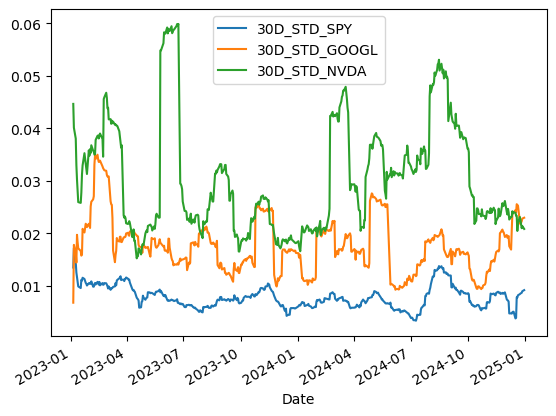

In [85]:
full_financial_data[[f"{window}_STD_{stock}"for stock in stocks]].plot()

In [87]:
full_financial_data[[f"{window}_EXCESS_RETURN_{stock}" for stock in stocks]].corr()

,30D_EXCESS_RETURN_SPY,30D_EXCESS_RETURN_GOOGL,30D_EXCESS_RETURN_NVDA
30D_EXCESS_RETURN_SPY,1.000000,0.238096,0.609195
30D_EXCESS_RETURN_GOOGL,0.238096,1.000000,0.255285
30D_EXCESS_RETURN_NVDA,0.609195,0.255285,1.000000


<Axes: xlabel='30D_EXCESS_RETURN_SPY', ylabel='30D_EXCESS_RETURN_NVDA'>

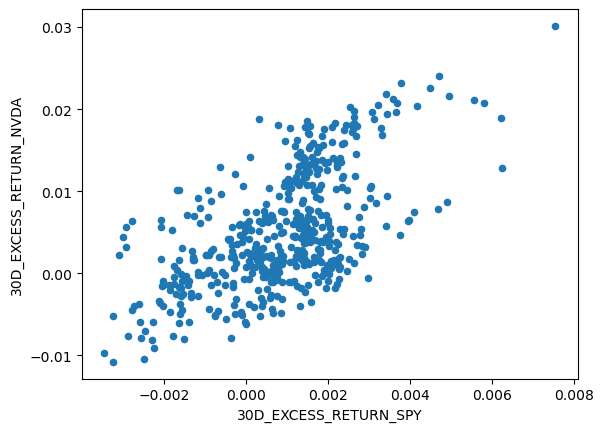

In [89]:
full_financial_data.plot(x=f'{window}_EXCESS_RETURN_{stocks[0]}',y=f'{window}_EXCESS_RETURN_{stocks[2]}',kind='scatter')

In [99]:
daily_market_excess = (full_financial_data[f"SIMPLE_{stocks[0]}"] - full_financial_data[f"{bond_type}"]).dropna()
daily_stock_excess = (full_financial_data[f"SIMPLE_{stocks[2]}"] - full_financial_data[f"{bond_type}"]).dropna()

fitted_line =  sc.linregress(daily_market_excess,daily_stock_excess)

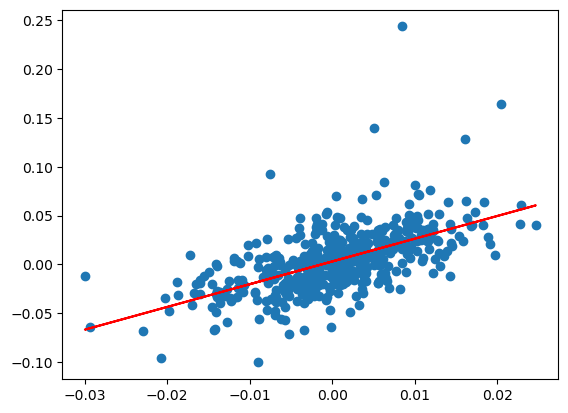

In [101]:
plt.scatter(daily_market_excess,daily_stock_excess)
plt.plot(daily_market_excess,fitted_line.intercept + fitted_line.slope * daily_market_excess,color='red')

In [105]:
fv, c, r, t, n = symbols('f c r t n',real=True)

present_value_sym = (n*c/r) + (fv - (n*c/r))*(1+(r/n))**(-n*t)
duration_sym = simplify(-diff(present_value_sym,r)/present_value_sym)
convexity_sym = simplify(diff(present_value_sym,r,r)/present_value_sym)

present_value_f = lambdify((r,fv,c,t,n),present_value_sym)
duration_f = lambdify((r,fv,c,t,n),duration_sym)
convexity_f = lambdify((r,fv,c,t,n),convexity_sym)

present_value_fv = np.vectorize(present_value_f)
duration_fv = np.vectorize(duration_f)
convexity_fv = np.vectorize(convexity_f)

In [117]:
@np.vectorize
def bond_pv(interest_rate, face_value, coupon, time, periods):
    n = time * periods
    cash_flow = [coupon for _ in range(n)]
    cash_flow[-1] = cash_flow[-1] + face_value
    cash_flow = [0] + cash_flow
    pv = npv(interest_rate/periods, np.array(cash_flow),False)

    return pv

def duration_pv(interest_rates, face_value, coupon, time, periods):
    pvs = bond_pv(interest_rates,face_value,coupon,time,periods)
    derivative_results = deriv(bond_pv, interest_rates,args=([face_value,coupon,time,periods]))
    return (derivative_results.x,-np.divide(derivative_results.df,pvs))

def convexity_pv(interest_rates,face_value,coupon,time,periods):
    pvs = bond_pv(interest_rates,face_value,coupon,time,periods)
    derivative_results = deriv(bond_pv, interest_rates,args=([face_value,coupon,time,periods]))
    return (derivative_results.x, np.divide(np.gradient(derivative_results.df,derivative_results.x),pvs))


In [123]:
face_value = 1000
coupon_value = 10
time_years = 5
coupons_per_year = 2
step = 150
rates = np.linspace(0.001,0.5,step)

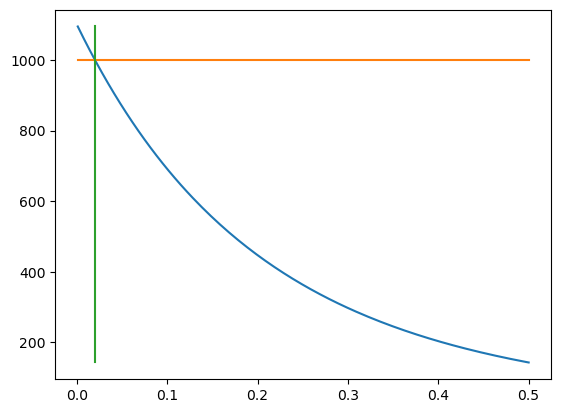

In [124]:
pvs_symbolic = present_value_fv(rates,face_value,coupon_value,time_years,coupons_per_year)

plt.plot(rates,pvs_symbolic)
plt.plot(rates,[face_value for _ in range(step)])
plt.plot([(coupons_per_year)*(coupon_value)/(face_value) for _ in range(step)],pvs_symbolic)

In [125]:
dur_symbolic = duration_fv(rates,face_value,coupon_value,time_years,coupons_per_year)
convex_symbolic = convexity_fv(rates,face_value,coupon_value,time_years,coupons_per_year)

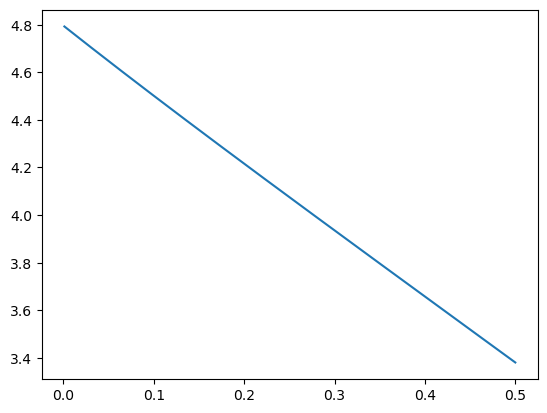

In [126]:
plt.plot(rates,dur_symbolic)

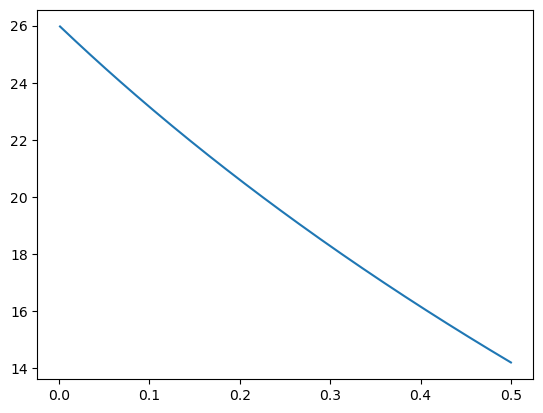

In [127]:
plt.plot(rates,convex_symbolic)

In [128]:
start = DT(2024,1,1)
end = DT(2024,12,31)
gdp_data_call  = pdr.fred.FredReader(['GDPC1','UNRATE','CPIAUCSL','FEDFUNDS','PCE','DGS3MO'],start,end)

In [129]:
gdp_data_call.read()

,GDPC1,UNRATE,CPIAUCSL,FEDFUNDS,PCE,DGS3MO
DATE,,,,,,
2024-01-01,23053.545,3.7,309.794,5.33,19308.5,NaN
2024-01-02,NaN,NaN,NaN,NaN,NaN,5.46
2024-01-03,NaN,NaN,NaN,NaN,NaN,5.48
2024-01-04,NaN,NaN,NaN,NaN,NaN,5.48
2024-01-05,NaN,NaN,NaN,NaN,NaN,5.47
...,...,...,...,...,...,...
2024-12-25,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-26,NaN,NaN,NaN,NaN,NaN,4.35
2024-12-27,NaN,NaN,NaN,NaN,NaN,4.31
